In [1]:
!sudo apt-get update
!sudo apt-get install -y swig g++ python3-dev
!pip install gymnasium[box2d] torch


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,659 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [77.5 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu 

Initializing environment: BipedalWalker-v3
Observation dimension: 24, Action dimension: 4
Starting ARS Training...
Iteration: 10/500, Reward: -119.41, Avg Reward (Last 10): -79.92, Time: 90.0s
Iteration: 20/500, Reward: -100.20, Avg Reward (Last 10): -102.08, Time: 146.5s
Iteration: 30/500, Reward: -104.04, Avg Reward (Last 10): -92.06, Time: 190.6s
Iteration: 40/500, Reward: -78.87, Avg Reward (Last 10): -103.12, Time: 238.8s
Iteration: 50/500, Reward: -105.95, Avg Reward (Last 10): -103.64, Time: 307.7s
Iteration: 60/500, Reward: -69.30, Avg Reward (Last 10): -102.32, Time: 389.7s
Iteration: 70/500, Reward: -132.02, Avg Reward (Last 10): -83.70, Time: 467.3s
Iteration: 80/500, Reward: -107.21, Avg Reward (Last 10): -86.85, Time: 523.1s
Iteration: 90/500, Reward: -53.78, Avg Reward (Last 10): -94.87, Time: 595.6s
Iteration: 100/500, Reward: -127.61, Avg Reward (Last 10): -89.85, Time: 671.0s
Iteration: 110/500, Reward: -89.15, Avg Reward (Last 10): -83.01, Time: 749.0s
Iteration: 120/

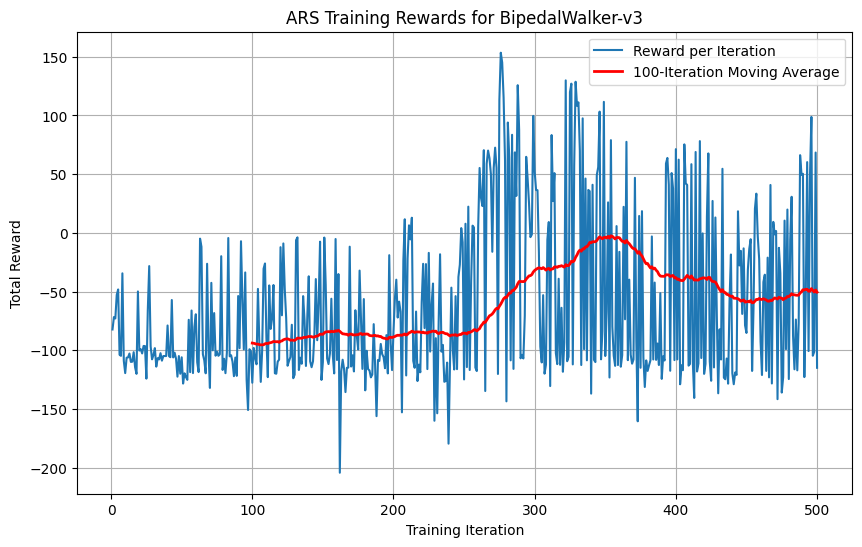


Running trained policy...
Initializing environment: BipedalWalker-v3
Observation dimension: 24, Action dimension: 4
Policy weights and state filter loaded from ars_bipedalwalker_weights.pkl
Evaluation episode 1 reward: -130.86
Evaluation episode 2 reward: -84.29
Evaluation episode 3 reward: 103.25
Evaluation episode 4 reward: -46.39
Evaluation episode 5 reward: 75.68


In [8]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import time

class Config:
    def __init__(self):
        self.env = "BipedalWalker-v3"
        self.sd = 1
        self.iters = 500
        self.nd = 16
        self.nb = 8
        self.lr = 0.02
        self.ns = 0.03
        self.explr = 0.01
        self.alpha = 0.1
        self.max_steps = 1600
        self.save_path = "ars_bipedalwalker_weights.pkl"
        self.plot_path = "ars_bipedalwalker_rewards.png"
        self.log_every = 10

class Normalizer:
    def __init__(self, dim, alpha=0.001):
        self.m = np.zeros(dim, dtype=np.float64)
        self.v = np.ones(dim, dtype=np.float64)
        self.c = 0
        self.a = alpha

    def update(self, x):
        x = np.asarray(x, dtype=np.float64)
        self.c += 1
        d = x - self.m
        self.m += d / self.c
        d2 = x - self.m
        self.v += d * d2

    def ema(self, x):
        x = np.asarray(x, dtype=np.float64)
        self.m = (1 - self.a) * self.m + self.a * x
        self.v = (1 - self.a) * self.v + self.a * np.square(x - self.m)
        self.c += 1

    def norm(self, x):
        s = np.sqrt(self.v + 1e-8)
        return (x - self.m) / s

    def get(self):
        return {'mean': self.m, 'var': self.v, 'n': self.c}

    def set(self, p):
        self.m = p['mean']
        self.v = p['var']
        self.c = p['n']

class Policy:
    def __init__(self, s, a, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.w = np.zeros((a, s), dtype=np.float64)

    def act(self, x, noise=0.0):
        y = self.w @ x
        if noise > 0:
            y += np.random.randn(y.shape[0]) * noise
        return np.clip(y, -1.0, 1.0)

    def get(self):
        return self.w

    def set(self, w):
        self.w = w

class Agent:
    def __init__(self, cfg):
        self.cfg = cfg
        print(f"Initializing environment: {cfg.env}")
        tmp = gym.make(cfg.env)
        self.s_dim = tmp.observation_space.shape[0]
        self.a_dim = tmp.action_space.shape[0]
        tmp.close()
        print(f"Observation dimension: {self.s_dim}, Action dimension: {self.a_dim}")

        self.policy = Policy(self.s_dim, self.a_dim, seed=cfg.sd)
        self.filter = Normalizer(self.s_dim, alpha=cfg.alpha)
        np.random.seed(cfg.sd)
        self.rewards = []

    def run(self, delta=None, dir=None):
        w = self.policy.get()
        p = Policy(self.s_dim, self.a_dim)

        if delta is not None and dir is not None:
            p.set(w + dir * delta)
        else:
            p.set(w)

        env = gym.make(self.cfg.env, max_episode_steps=self.cfg.max_steps)
        obs, _ = env.reset(seed=np.random.randint(0, 10000))
        ret = 0.0
        steps = 0
        done = False
        trunc = False

        while not done and not trunc:
            self.filter.ema(obs)
            norm_obs = self.filter.norm(obs)
            act = p.act(norm_obs, noise=self.cfg.explr)
            obs, r, done, trunc, _ = env.step(act)
            ret += r
            steps += 1

        env.close()
        return ret

    def train(self):
        t0 = time.time()
        print("Starting ARS Training...")

        for i in range(self.cfg.iters):
            dirs = np.random.randn(self.cfg.nd, self.a_dim, self.s_dim)
            d_scaled = self.cfg.ns * dirs

            r_pos = np.zeros(self.cfg.nd)
            r_neg = np.zeros(self.cfg.nd)

            for j in range(self.cfg.nd):
                r_pos[j] = self.run(delta=d_scaled[j], dir=1)
                r_neg[j] = self.run(delta=d_scaled[j], dir=-1)

            max_r = np.maximum(r_pos, r_neg)
            idx = np.argsort(max_r)[-self.cfg.nb:]
            sel_r = max_r[idx]
            std_r = np.std(sel_r) + 1e-6

            step = np.zeros_like(self.policy.w)
            for j in idx:
                step += (r_pos[j] - r_neg[j]) * dirs[j]

            upd = self.cfg.lr / (self.cfg.nb * std_r)
            self.policy.w += upd * step

            curr_r = self.run()
            self.rewards.append(curr_r)

            if (i + 1) % self.cfg.log_every == 0:
                t = time.time() - t0
                avg = np.mean(self.rewards[-10:]) if len(self.rewards) >= 10 else np.mean(self.rewards)
                print(f"Iteration: {i + 1}/{self.cfg.iters}, "
                      f"Reward: {curr_r:.2f}, "
                      f"Avg Reward (Last 10): {avg:.2f}, "
                      f"Time: {t:.1f}s")

        print(f"\nTraining finished after {self.cfg.iters} iterations.")
        print(f"Final average reward (last 100): {np.mean(self.rewards[-100:]):.2f}")
        self.save()
        self.plot()

    def save(self):
        d = {
            'weights': self.policy.get(),
            'state_filter': self.filter.get()
        }
        p = self.cfg.save_path
        try:
            with open(p, 'wb') as f:
                pickle.dump(d, f)
            print(f"Policy weights and state filter saved to {p}")
        except Exception as e:
            print(f"Error saving policy: {e}")

    def load(self, p):
        try:
            with open(p, 'rb') as f:
                d = pickle.load(f)
            self.policy.set(d['weights'])
            self.filter.set(d['state_filter'])
            print(f"Policy weights and state filter loaded from {p}")
        except FileNotFoundError:
            print(f"Error: Policy file not found at {p}")
        except Exception as e:
            print(f"Error loading policy: {e}")

    def plot(self):
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(self.rewards) + 1), self.rewards, label='Reward per Iteration')
        if len(self.rewards) >= 100:
            avg = np.convolve(self.rewards, np.ones(100)/100, mode='valid')
            plt.plot(range(100, len(self.rewards) + 1), avg, label='100-Iteration Moving Average', color='red', linewidth=2)

        plt.xlabel("Training Iteration")
        plt.ylabel("Total Reward")
        plt.title(f"ARS Training Rewards for {self.cfg.env}")
        plt.legend()
        plt.grid(True)
        try:
            plt.savefig(self.cfg.plot_path)
            print(f"Reward plot saved to {self.cfg.plot_path}")
        except Exception as e:
            print(f"Error saving plot: {e}")
        plt.show()

if __name__ == "__main__":
    cfg = Config()
    ag = Agent(cfg)
    ag.train()

    print("\nRunning trained policy...")
    ag2 = Agent(cfg)
    ag2.load(cfg.save_path)
    for i in range(5):
        r = ag2.run()
        print(f"Evaluation episode {i+1} reward: {r:.2f}")